In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import network_maps

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
fig_size = (16, 2)

In [2]:
# Check out our Fjord5G paper for more 5G data

# List of directories to iterate through
data_dirs = [
    './../../Data/MQTT/2025-03-27-wan/',
]

df_list = []

for data_dir in data_dirs:
    print(f"Processing directory: {data_dir}")
    list_of_files = os.listdir(data_dir)
    list_of_files.sort()
    num_files = len(list_of_files)
    print(f'Number of files in {data_dir}: {num_files}')

    for file in list_of_files:
        # Skipping files that do not end with ".gzip"
        if not file.endswith(".gzip"):
            continue
        temp_df = pd.read_parquet(os.path.join(data_dir, file))
        df_list.append(temp_df)

# Concatenate all DataFrames
#df = pd.concat(df_list, ignore_index=True)
df = pd.concat(df_list)

print("Final DataFrame shape:", df.shape)
df.info()

Processing directory: ./../../Data/MQTT/2025-03-27-wan/
Number of files in ./../../Data/MQTT/2025-03-27-wan/: 20
Final DataFrame shape: (71301, 48)
<class 'pandas.core.frame.DataFrame'>
Index: 71301 entries, 0 to 2900
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   identity                    71301 non-null  object
 1   time                        71301 non-null  object
 2   date                        71301 non-null  object
 3   RouterboardModel            71301 non-null  object
 4   CurrentFirmware             71301 non-null  object
 5   UpgradeFirmware             71301 non-null  object
 6   @timestamp                  71301 non-null  object
 7   gps.lat                     71301 non-null  object
 8   gps.lon                     71301 non-null  object
 9   gps.altitude                71301 non-null  object
 10  gps.speed                   71301 non-null  object
 11  gps.heading     

In [3]:
# Infer objects, then convert dtypes
df = df.infer_objects().convert_dtypes()

for column in df.columns:
        try:
            df[column] = pd.to_numeric(df[column])
        except (ValueError, TypeError):
            pass  # Skip columns that cannot be converted

# Rename timestamp from Python and keep it for future use
# It is unreliable if a lot of messages come at the same time due to congestion
df['timestamp_python'] = df.pop('@timestamp')

# It is better to rely on timestamps from the router rather than ElasticSearch
df['timestamp_router'] = pd.to_datetime(df['date'] + ' ' +  df['time'])
df.drop(columns=['date', 'time'], inplace=True)
df = df.sort_values(by=['timestamp_router'])
df = df.set_index('timestamp_router', drop=False)
#df = df.reset_index()

#df = df.query("identity == 'CAU-4329'")

# Convert Data Class into integer mapping
dataclass_mapping = {'': 0, 'LTE': 1, '5G NSA': 2, '5G SA': 3}
df['lte.lDataClassInt'] = df['lte.lDataClass'].map(dataclass_mapping)

# Fix wrong scaling on Rsrq and NrRsrq
# If the value is -12dB, it is shown as -120
df['lte.lRsrq'] = df['lte.lRsrq'] / 10
df['lte.lNrRsrq'] = df['lte.lNrRsrq'] / 10

# use fillna(0) to fill the NA on the first row
df['Handover'] = df['lte.lCurrentCellid'].diff().fillna(0).ne(0).astype(float)

df['Handover_predicted'] = df['Handover'].shift(-1, fill_value=0)

df['Speed'] = pd.to_numeric(df['gps.speed'].str.split().str[0])

In [4]:
df['identity'].unique()

<StringArray>
['CAU-0C', '5G-DTAG-WAVELAB', 'CAU-4329', '5G-D2-WAVELAB']
Length: 4, dtype: string

In [5]:
df.head()

,identity,RouterboardModel,CurrentFirmware,UpgradeFirmware,gps.lat,gps.lon,gps.altitude,gps.speed,gps.heading,lte.lModel,lte.lRevision,lte.lCurrentOperator,lte.lCurrentCellid,lte.lEnbId,lte.lSectorId,lte.lPhyCellId,lte.lDataClass,lte.lPrimaryBand,lte.lcaBand,lte.lulcaBand,lte.lDlModulation,lte.lCqi,lte.lRi,lte.lMcs,lte.lRssi,lte.lRsrp,lte.lRsrq,lte.lSinr,lte.lNrDlModulation,lte.lNrRsrp,lte.lNrRsrq,lte.lNrSinr,lte.lrxpacketspersecond,lte.lrxbitspersecond,lte.lfprxpacketspersecond,lte.lfprxbitspersecond,lte.lrxdropspersecond,lte.lrxerrorspersecond,lte.ltxpacketspersecond,lte.ltxbitspersecond,lte.lfptxpacketspersecond,lte.lfptxbitspersecond,lte.ltxdropspersecond,lte.ltxqueuedropspersecond,lte.ltxerrorspersecond,timestamp_python,timestamp_router,lte.lDataClassInt,Handover,Handover_predicted,Speed
timestamp_router,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-03-27 10:35:02,CAU-0C,D53G-5HacD2HnD,7.9.2,7.18.2,54.336541,10.16529,5.400000 m,11.469436 km/h,4.830000 deg. True,RG502Q-EA,RG502QEAAAR13A03M4G,Telekom.de,49304075.0,192594.0,11.0,274.0,5G NSA,B3@20Mhz earfcn: 1300 phy-cellid: 274,"[n78@90Mhz earfcn: 641760 phy-cellid: 442, B3@...",[],qpsk,6.0,1.0,0.0,-47.0,-85.0,-17.0,-2.0,qpsk,-73.0,-12.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,2025-03-27T10:35:02.678693+01:00,2025-03-27 10:35:02,2,0.0,1.0,11.469436
2025-03-27 10:35:02,5G-DTAG-WAVELAB,S53UG+M-5HaxD2HaxD,7.9,7.17.2,54.335853,10.165646,-112.699997 m,17.132853 km/h,4.200000 deg. True,RG502Q-EA,RG502QEAAAR13A03M4G,Telekom.de,27107074.0,105887.0,2.0,384.0,5G NSA,B3@20Mhz earfcn: 1300 phy-cellid: 384,"[n78@90Mhz earfcn: 641760 phy-cellid: 398, B20...",[],qpsk,4.0,1.0,0.0,-41.0,-73.0,-12.0,4.0,qpsk,-70.0,-12.0,7.0,341,496688,341,496688,0,0,79,315664,0,0,0,0,0,2025-03-27T10:35:02.916555+01:00,2025-03-27 10:35:02,2,1.0,1.0,17.132853
2025-03-27 10:35:02,CAU-4329,D53G-5HacD2HnD,7.14.3,7.18.2,54.336574,10.165365,-0.900000 m,11.465732 km/h,5.400000 deg. True,RG520F-EU,RG520FEUEAR03A05M4G,vodafone.de,148.0,<NA>,<NA>,94.0,5G SA,n78@80Mhz earfcn: 631968 phy-cellid: 94,[],[],qpsk,5.0,2.0,2.0,<NA>,-89.0,-11.0,1.0,,<NA>,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,2025-03-27T10:35:03.114303+01:00,2025-03-27 10:35:02,3,1.0,0.0,11.465732
2025-03-27 10:35:03,5G-D2-WAVELAB,S53UG+M-5HaxD2HaxD,7.9,7.17.2,54.336591,10.165251,6.200000 m,11.502772 km/h,5.370000 deg. True,RG502Q-EA,RG502QEAAAR13A03M4G,vodafone.de,148.0,<NA>,<NA>,94.0,5G SA,n78@80Mhz earfcn: 631968 phy-cellid: 94,[],[],16qam,13.0,2.0,6.0,<NA>,-83.0,-10.0,10.0,,<NA>,<NA>,<NA>,74,148032,74,148032,0,0,1047,7113008,0,0,0,0,0,2025-03-27T10:35:03.517296+01:00,2025-03-27 10:35:03,3,0.0,1.0,11.502772
2025-03-27 10:35:03,CAU-0C,D53G-5HacD2HnD,7.9.2,7.18.2,54.336569,10.165295,5.300000 m,11.397208 km/h,5.620000 deg. True,RG502Q-EA,RG502QEAAAR13A03M4G,Telekom.de,49304075.0,192594.0,11.0,274.0,5G NSA,B3@20Mhz earfcn: 1300 phy-cellid: 274,"[n78@90Mhz earfcn: 641760 phy-cellid: 442, B3@...",[],qpsk,6.0,1.0,0.0,-47.0,-85.0,-17.0,-2.0,qpsk,-73.0,-12.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,2025-03-27T10:35:03.681554+01:00,2025-03-27 10:35:03,2,1.0,1.0,11.397208


In [6]:
df.columns = df.columns.str.removeprefix("gps.")
df.columns = df.columns.str.removeprefix("lte.")

In [7]:
df_CAU_4329 = df.query("identity == 'CAU-4329'")
df_CAU_0C = df.query("identity == 'CAU-0C'")
# df_D2 = df.query("identity == '5G-D2-WAVELAB'") # Not used in the notebook
# df_DTAG = df.query("identity == '5G-DTAG-WAVELAB'") # Not used in the notebook

In [8]:
df_CAU_4329.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17822 entries, 2025-03-27 10:35:02 to 2025-03-27 15:32:29
Data columns (total 51 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   identity                17822 non-null  string        
 1   RouterboardModel        17822 non-null  string        
 2   CurrentFirmware         17822 non-null  string        
 3   UpgradeFirmware         17822 non-null  string        
 4   lat                     17822 non-null  Float64       
 5   lon                     17822 non-null  Float64       
 6   altitude                17822 non-null  string        
 7   speed                   17822 non-null  string        
 8   heading                 17822 non-null  string        
 9   lModel                  17822 non-null  string        
 10  lRevision               17822 non-null  string        
 11  lCurrentOperator        17822 non-null  string        
 12  lCurrentCel

In [9]:
df_CAU_4329.describe()

,lat,lon,lCurrentCellid,lEnbId,lSectorId,lPhyCellId,lCqi,lRi,lMcs,lRssi,lRsrp,lRsrq,lSinr,lNrRsrp,lNrRsrq,lNrSinr,lrxpacketspersecond,lrxbitspersecond,lfprxpacketspersecond,lfprxbitspersecond,lrxdropspersecond,lrxerrorspersecond,ltxpacketspersecond,ltxbitspersecond,lfptxpacketspersecond,lfptxbitspersecond,ltxdropspersecond,ltxqueuedropspersecond,ltxerrorspersecond,timestamp_router,lDataClassInt,Handover,Handover_predicted,Speed
count,17822.0,17822.0,17816.0,0.0,0.0,17816.0,17822.0,17822.0,17822.0,0.0,17816.0,17807.0,17816.0,0.0,0.0,0.0,17822.0,17822.0,17822.0,17822.0,17822.0,17822.0,17822.0,17822.0,17822.0,17822.0,17822.0,17822.0,17822.0,17822,17822.0,17822.000000,17822.000000,17822.000000
mean,54.362981,10.173486,1246.690166,<NA>,<NA>,488.576897,9.967849,1.930479,7.046179,<NA>,-78.692299,-10.32549,13.231197,<NA>,<NA>,<NA>,1979.529514,20667078.467512,1979.701998,20890606.156436,0.0,0.0,1484.576647,15654685.206599,0.0,0.0,0.0,0.0,0.0,2025-03-27 13:03:45.816126208,3.0,0.911570,0.907474,9.642396
min,54.323819,10.153116,24.0,<NA>,<NA>,18.0,0.0,1.0,0.0,<NA>,-140.0,-20.0,-8.0,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-03-27 10:35:02,3.0,0.000000,0.000000,0.005556
25%,54.345422,10.160866,375.0,<NA>,<NA>,177.0,8.0,2.0,0.0,<NA>,-85.0,-11.0,8.0,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-03-27 11:49:24.249999872,3.0,1.000000,1.000000,9.095635
50%,54.356561,10.166575,1545.0,<NA>,<NA>,609.0,10.0,2.0,2.0,<NA>,-78.0,-10.0,13.0,<NA>,<NA>,<NA>,10.0,5280.0,10.0,6400.0,0.0,0.0,10.0,4768.0,0.0,0.0,0.0,0.0,0.0,2025-03-27 13:03:45.500000,3.0,1.000000,1.000000,10.146182
75%,54.373856,10.185613,1668.0,<NA>,<NA>,684.0,12.0,2.0,14.0,<NA>,-73.0,-10.0,19.0,<NA>,<NA>,<NA>,4872.0,50912640.0,4970.0,52509368.0,0.0,0.0,3862.25,40810398.0,0.0,0.0,0.0,0.0,0.0,2025-03-27 14:18:06.750000128,3.0,1.000000,1.000000,11.665748
max,54.422476,10.210295,415029.0,<NA>,<NA>,65535.0,15.0,4.0,31.0,<NA>,-44.0,-10.0,32.0,<NA>,<NA>,<NA>,26630.0,278556960.0,26657.0,281825072.0,0.0,0.0,5789.0,61214368.0,0.0,0.0,0.0,0.0,0.0,2025-03-27 15:32:29,3.0,1.000000,1.000000,19.631201
std,0.024619,0.016043,5410.5321,<NA>,<NA>,881.755269,2.778736,0.372808,8.748271,<NA>,7.885097,0.634542,7.083491,<NA>,<NA>,<NA>,2398.571642,25079600.391992,2415.907351,25531100.758541,0.0,0.0,2096.66562,22158122.234414,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.283927,0.289775,3.920230


<Axes: xlabel='timestamp_router'>

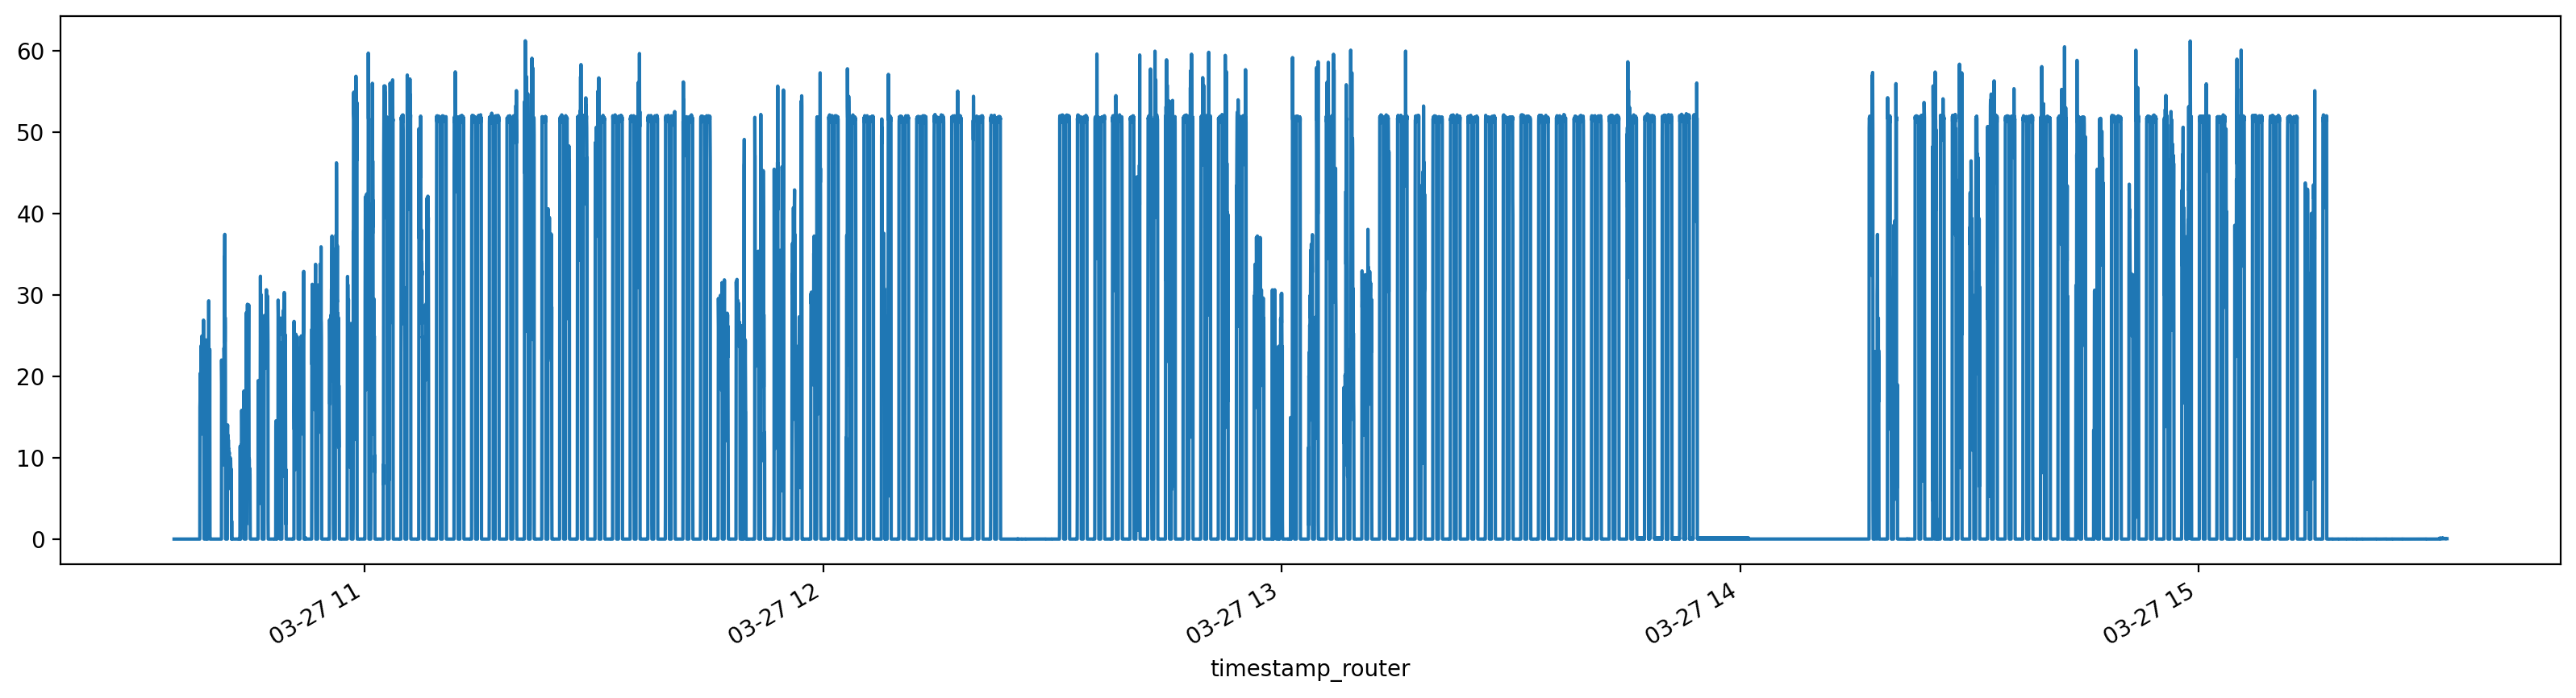

In [10]:
df_CAU_4329['ltxbitspersecond'].div(1000 * 1000).plot(figsize=(20, 5))

<Axes: xlabel='timestamp_router'>

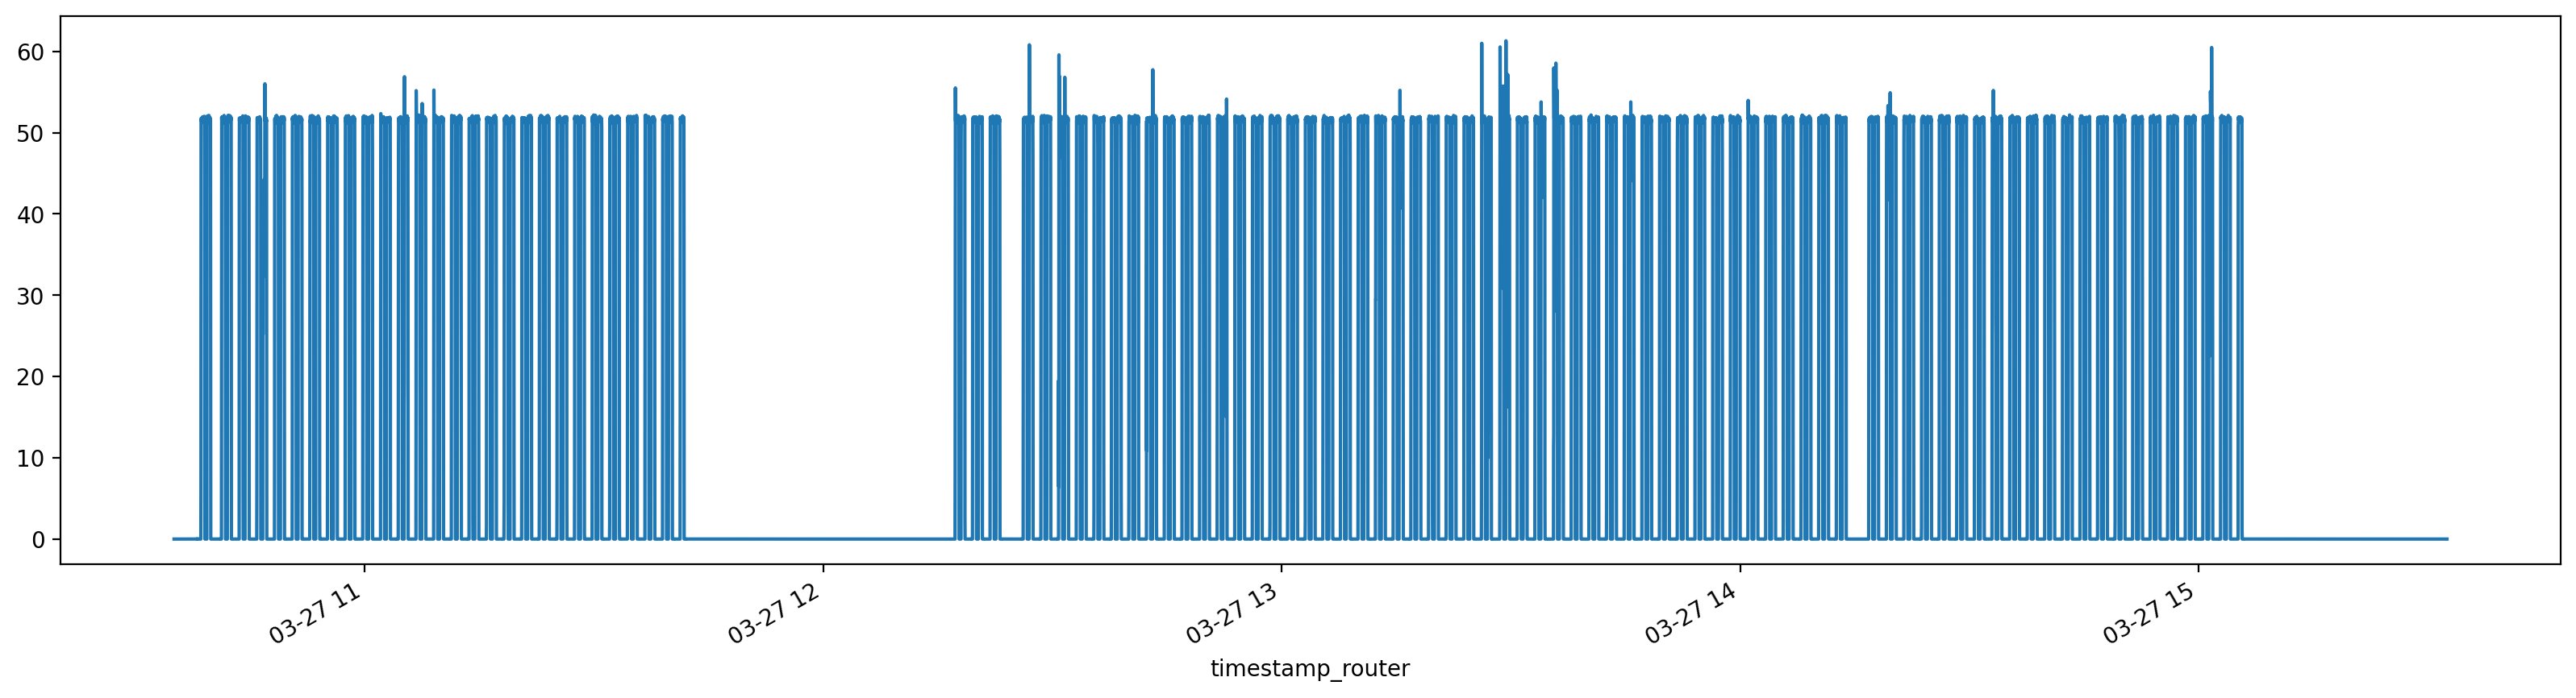

In [11]:
df_CAU_0C['ltxbitspersecond'].div(1000 * 1000).plot(figsize=(20, 5))

In [12]:
# You can change the metric up when the dataset is loaded to create maps for different metrics, here we are using CQI
network_maps.create_coverage_squares_with_metric(df_CAU_4329, 'CAU-4329', 'all', 'FjordLink', metric='lCqi')

/Users/birkandenizer/Git/FjordLink/network_maps.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lon_bin'] = pd.cut(df['lon'], bins=lon_bins, labels=lon_labels.keys(), right=False)
/Users/birkandenizer/Git/FjordLink/network_maps.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat_bin'] = pd.cut(df['lat'], bins=lat_bins, labels=lat_labels.keys(), right=False)
/Users/birkandenizer/Git/FjordLink/network_maps.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [13]:
# You can change the metric up when the dataset is loaded to create maps for different metrics, here we are using CQI
network_maps.create_coverage_squares_with_metric(df_CAU_0C, 'CAU-0C', 'all', 'FjordLink', metric='lCqi')

/Users/birkandenizer/Git/FjordLink/network_maps.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lon_bin'] = pd.cut(df['lon'], bins=lon_bins, labels=lon_labels.keys(), right=False)
/Users/birkandenizer/Git/FjordLink/network_maps.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat_bin'] = pd.cut(df['lat'], bins=lat_bins, labels=lat_labels.keys(), right=False)
/Users/birkandenizer/Git/FjordLink/network_maps.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

<Axes: xlabel='timestamp_router'>

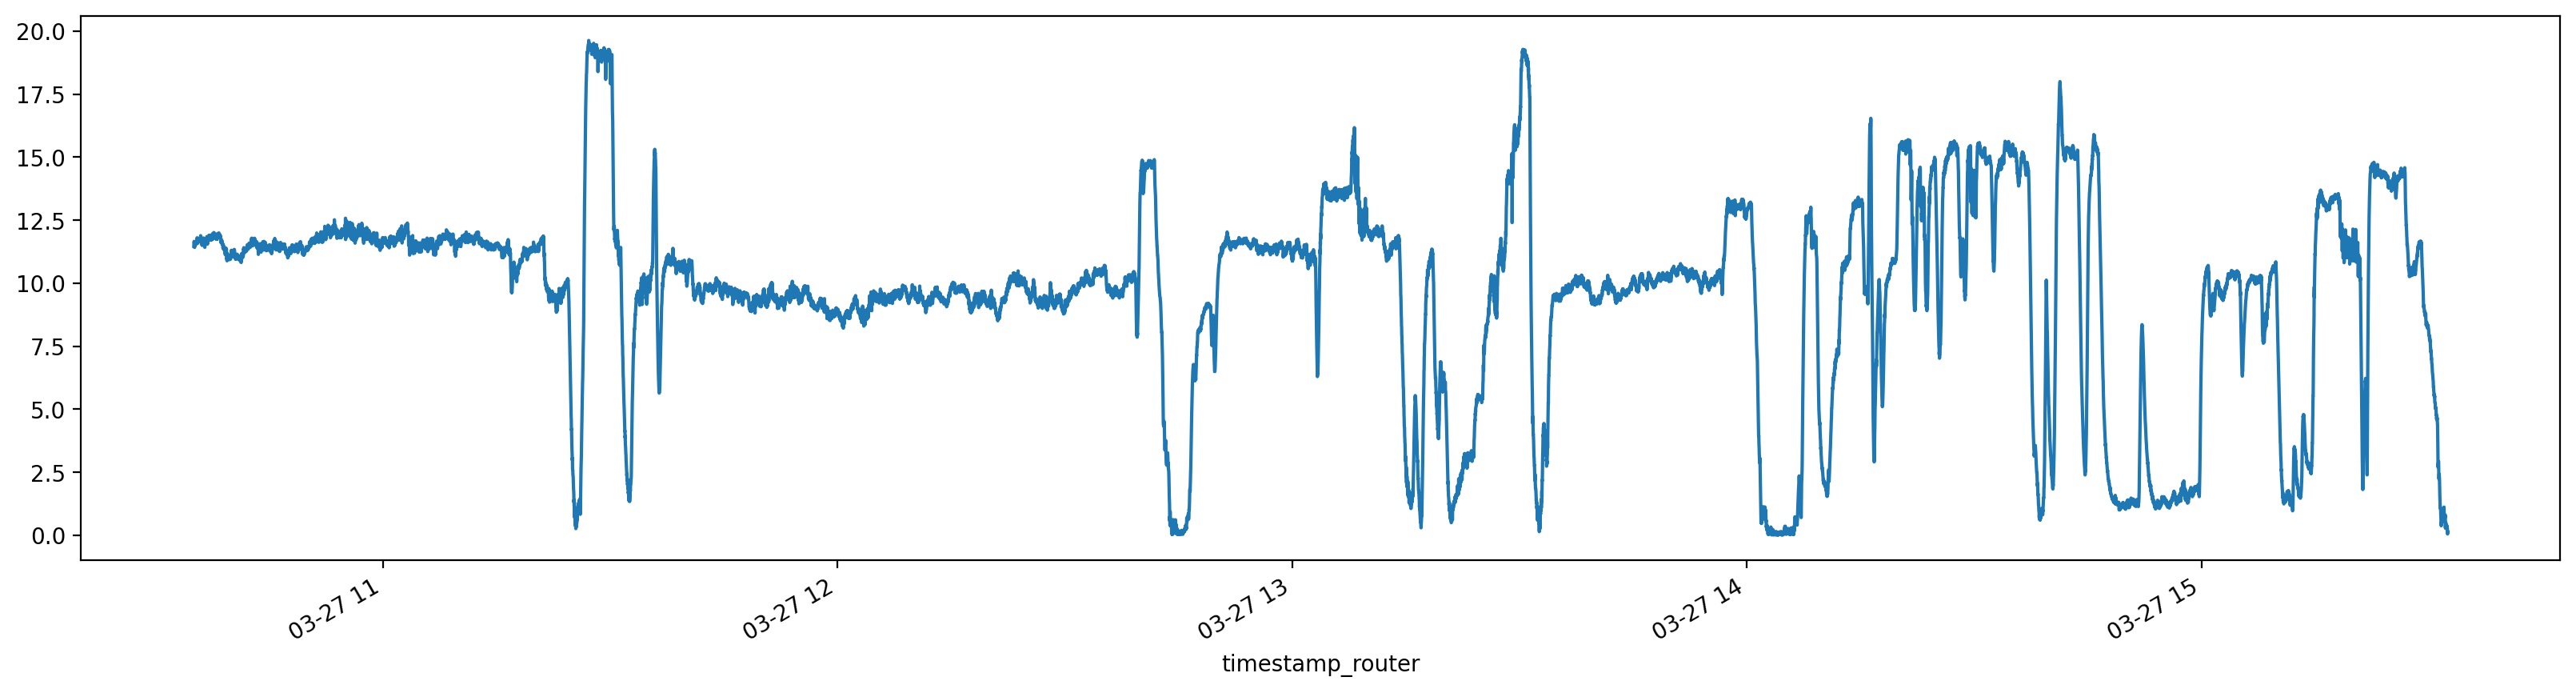

In [14]:
df_CAU_4329['Speed'].plot(figsize=(20, 5))

<Axes: xlabel='timestamp_router'>

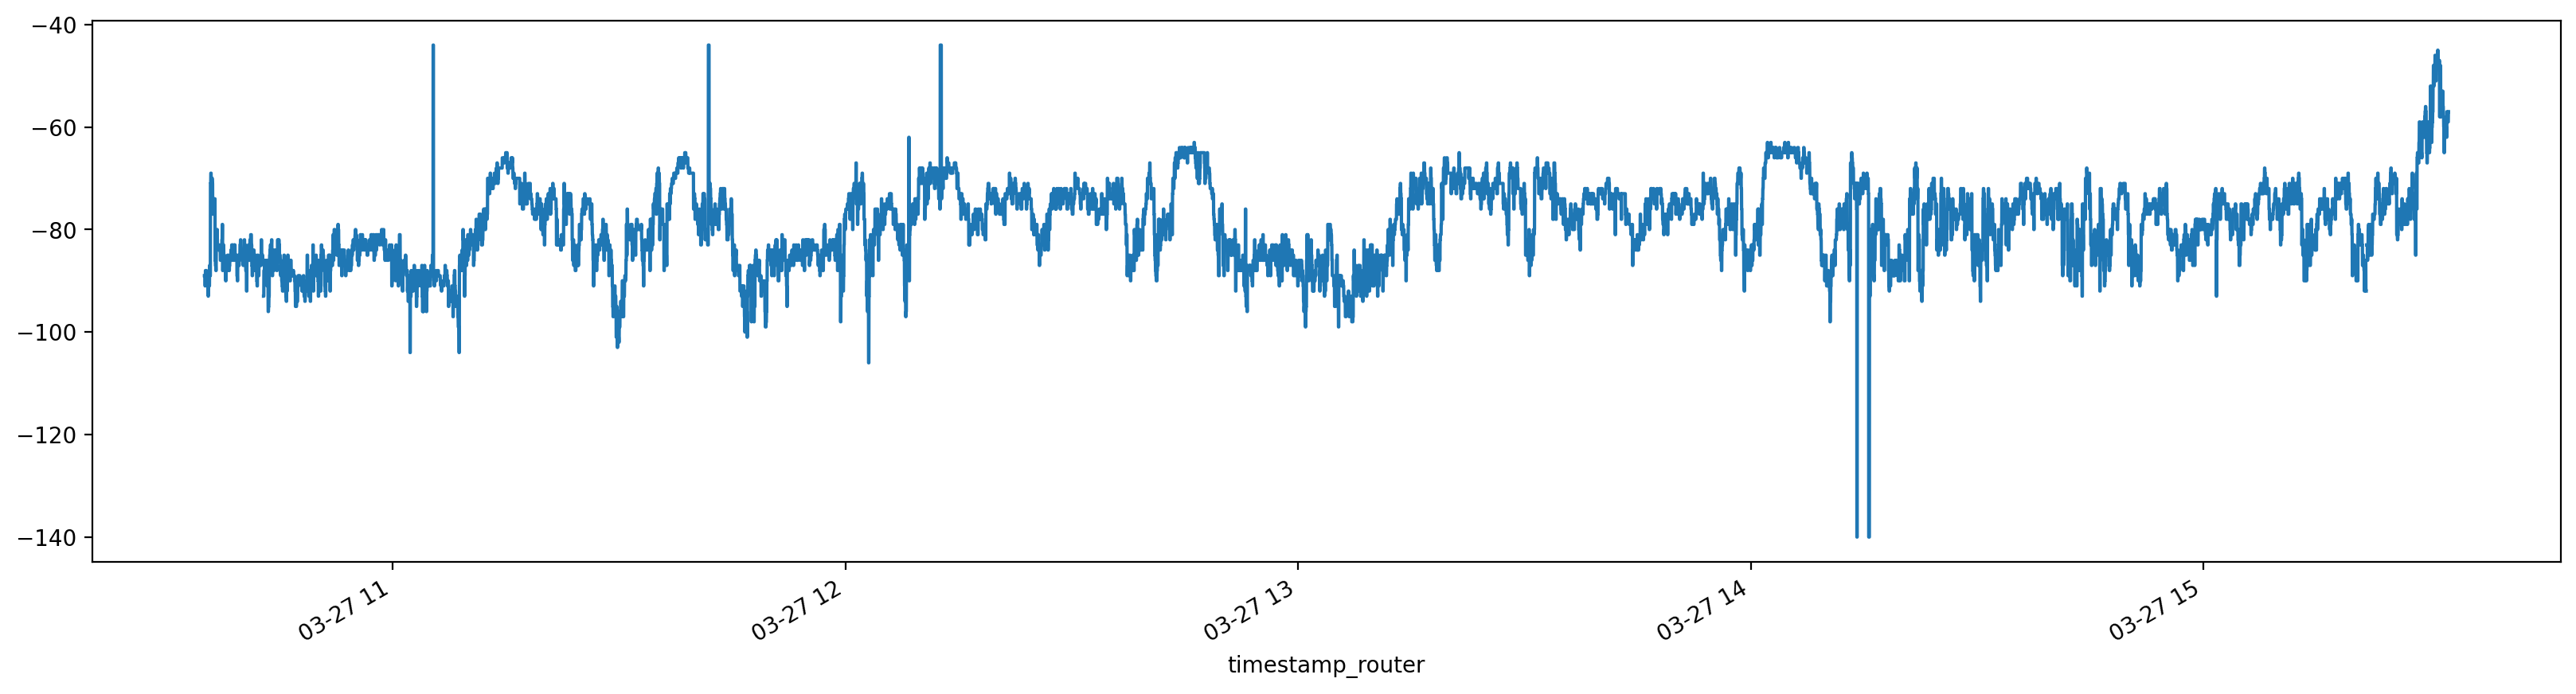

In [15]:
# This router uses only 5G SA, therefore RSRP metric is used
df_CAU_4329['lRsrp'].plot(figsize=(20, 5))

<Axes: xlabel='timestamp_router'>

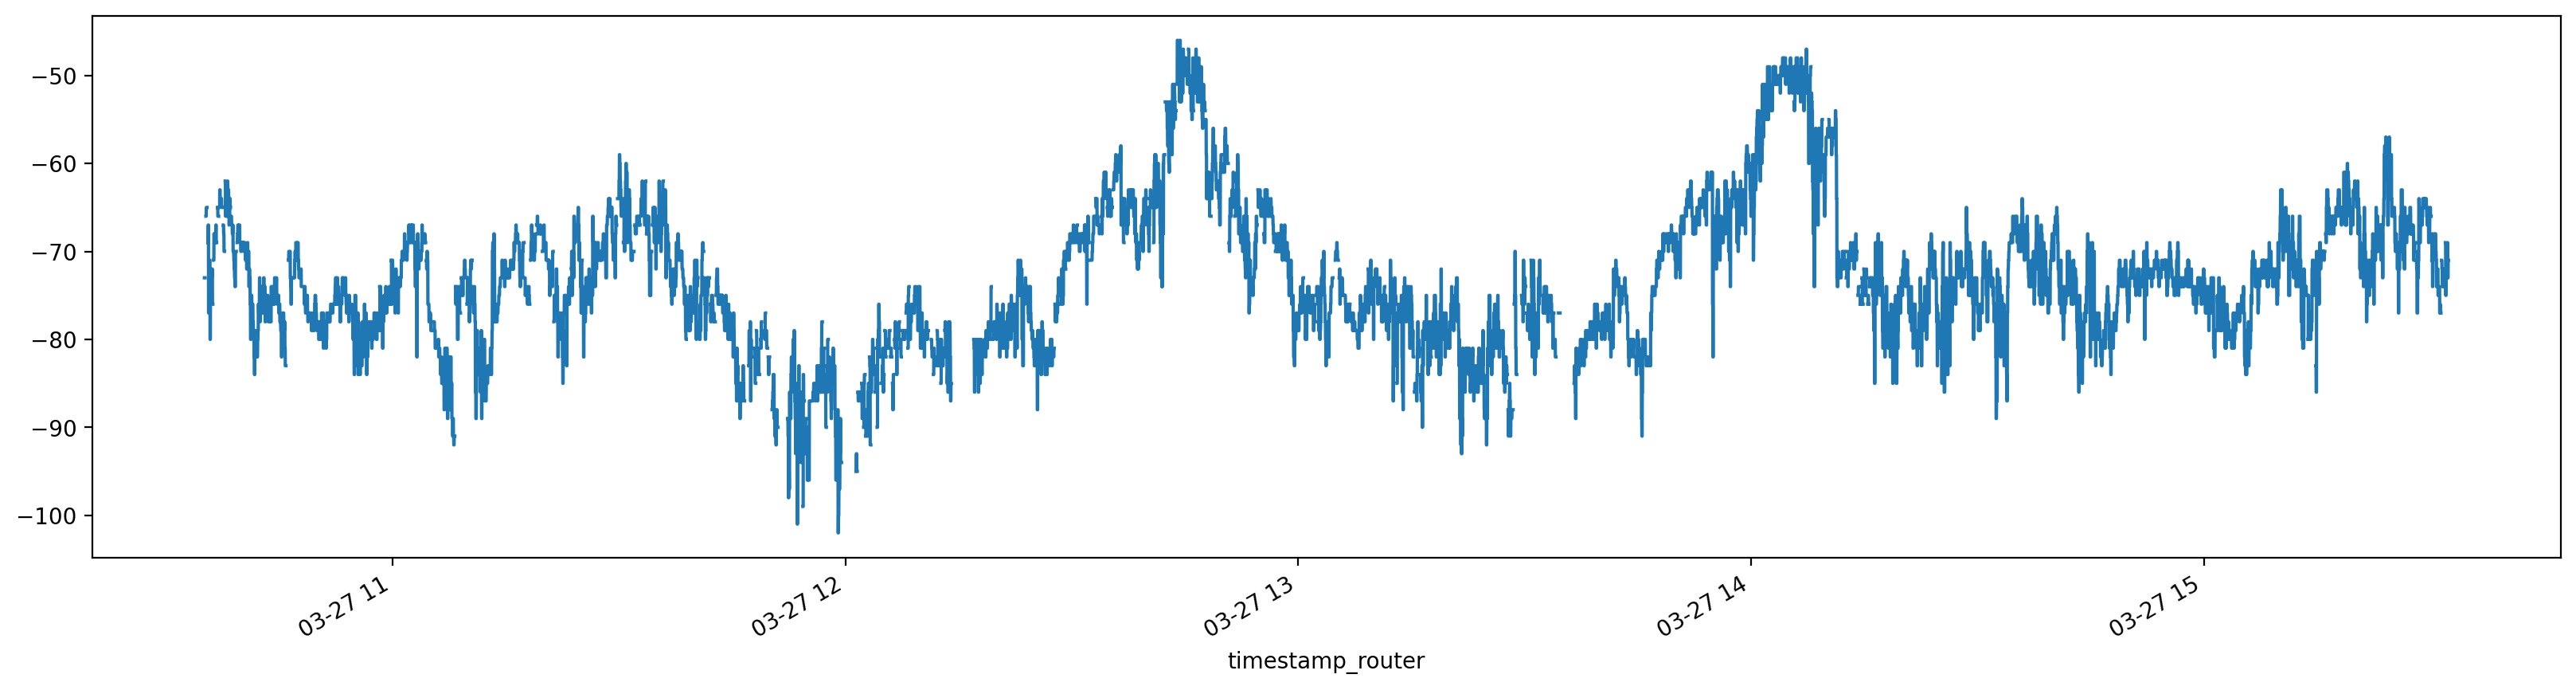

In [16]:
# This router uses only 5G NSA, therefore NR-RSRP metric is used
df_CAU_0C['lNrRsrp'].plot(figsize=(20, 5))